# Stroke Prediction: A Comparative Analysis of Machine Learning Models
## Capstone Project - Final Report

### 1. Introduction

**1.1 Global Health Context**
Stroke is a cerebrovascular accident that occurs when the flow of blood to the brain is blocked or when a blood vessel in the brain bursts, causing brain tissue to be deprived of necessary nutrients and oxygen. According to the World Health Organization (WHO), stroke is the second leading cause of death globally, responsible for approximately 11% of total deaths [1]. Beyond mortality, it is a leading cause of long-term disability, creating a massive burden on healthcare systems and families worldwide. Early identification of high-risk individuals is paramount for prevention, as up to 80% of strokes can be prevented by addressing modifiable risk factors such as hypertension, smoking, and obesity [1].

**1.2 Problem Statement**
The complexity of stroke etiology involves numerous physiological and lifestyle factors. Traditional clinical diagnosis relies heavily on manual assessment and imaging, which may not always be available for proactive screening in large populations. This project aims to leverage Machine Learning (ML) techniques to build a predictive model that can identify patients at high risk of stroke based on demographic and clinical parameters.

**1.3 Dataset Challenge**
The dataset used in this study is the **Stroke Prediction Dataset** sourced from Kaggle (originally sourced from fedesoriano) [2]. It contains clinical records for over 5,000 patients. A critical characteristic of this dataset—and medical datasets in general—is the severe class imbalance. The positive class (Stroke=1) represents only approx. 5% of the data. This creates a "needle in a haystack" problem where a standard model might achieve 95% accuracy by simply predicting "No Stroke" for everyone, which is clinically useless.

**1.4 Objective**
The primary objective is to develop a robust binary classification framework where $y=1$ denotes a stroke event. We will implement and compare eight distinct machine learning algorithms, ranging from parametric linear models to complex ensemble methods. We prioritize **Sensitivty (Recall)** over Precision or Accuracy, as the cost of a False Negative (missing a stroke risk) is catastrophic compared to a False Positive (unnecessary preventative screening).

**References**
> [1] World Health Organization. (n.d.). *Stroke, Cerebrovascular accident*. Retrieved from https://www.who.int/
> [2] fedesoriano. (n.d.). *Stroke Prediction Dataset*. Kaggle. Retrieved from https://www.kaggle.com/fedesoriano/stroke-prediction-dataset



### 2. Data Engineering & Preprocessing

Data preprocessing is the bedrock of robust machine learning. In medical data science, this phase is critical for ensuring that models effectively learn signals rather than noise. This section details the rigorous engineering steps taken to prepare the data for modeling, adhering to best practices in dimensionality reduction, imputation, and imbalance handling.

**2.1 Missing Value Imputation**
Real-world clinical data often suffers from missingness. In our dataset, the `bmi` (Body Mass Index) feature contains missing values.
*   **Theoretical Justification:** BMI in a general population tends to follow a normal or log-normal distribution. Replacing missing values with the **Mean** is a standard statistical approach that preserves the central tendency of the feature, ensuring we do not discard valuable patient records (rows) which would further reduce our minority class count.

**2.2 Encoding Categorical Variables**
Machine learning algorithms typically require numerical input. We employ two strategies:
*   **Label Encoding:** Applied to binary variables like `ever_married` and `Residence_type`. This transforms categories into $\{0, 1\}$ without increasing dimensionality.
*   **One-Hot Encoding:** Applied to nominal variables with no intrinsic ordering, such as `work_type` and `smoking_status`. This prevents the model from assuming a false ordinal relationship (e.g., creating a mathematical assumption that 'government job' > 'private job'). While this increases the feature space (Curse of Dimensionality), it is necessary for linear models to properly weight these categories.

**2.3 Handling Class Imbalance with SMOTE**
The most critical engineering step in this project is addressing the severe class imbalance (~95% vs ~5%). Standard learning algorithms optimize for accuracy, which leads to bias towards the majority class.
*   **Method:** We utilize **SMOTE (Synthetic Minority Over-sampling Technique)**.
*   **Theoretical Basis:** As introduced by Chawla et al. (2002), SMOTE does not simply duplicate existing minority samples (which leads to overfitting). Instead, it creates *synthetic* examples. Ideally, for a minority instance $x_i$, SMOTE finds its $k$-nearest neighbors in feature space. It then selects a neighbor $\hat{x}_i$ and creates a new sample $x_{new}$ along the line segment joining them: $x_{new} = x_i + \lambda \cdot (\hat{x}_i - x_i)$, where $\lambda \in [0, 1]$ [3].
*   **Constraint:** Crucially, SMOTE is applied **only to the training set** after splitting. Applying it before splitting would cause "data leakage," where synthetic versions of test samples appear in the training data, leading to overly optimistic and invalid results.

**References**
> [3] Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2002). SMOTE: synthetic minority over-sampling technique. *Journal of artificial intelligence research*, 16, 321-357.



In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report
from imblearn.over_sampling import SMOTE

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set(style="whitegrid")



Dataset Shape: (5110, 12)


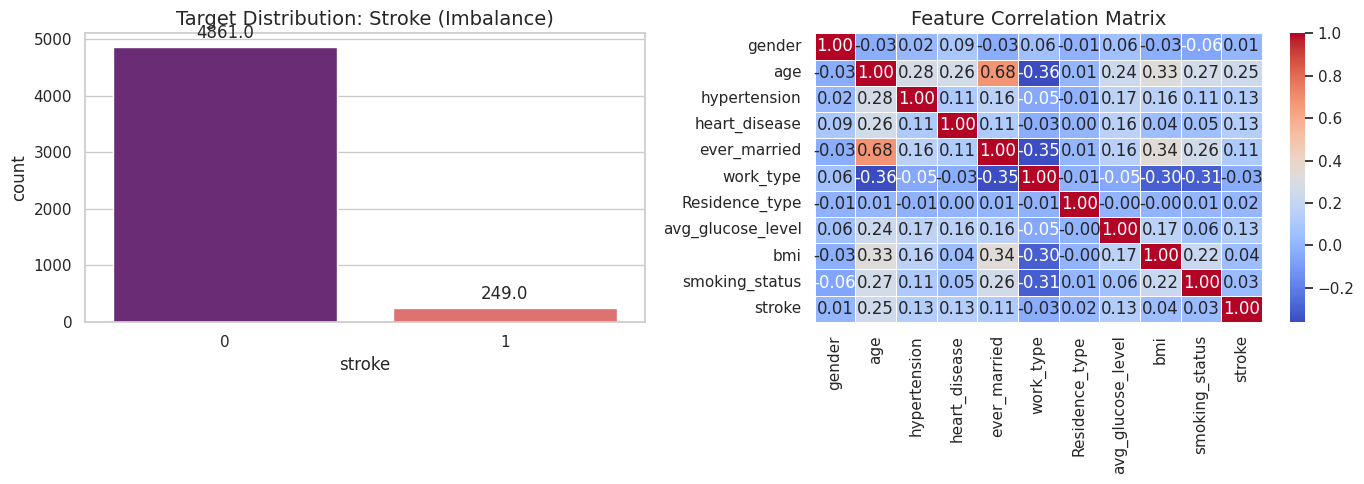

In [2]:
# 1. Load Data
# Note: Ensure 'healthcare-dataset-stroke-data.csv' is in the same directory
try:
    df = pd.read_csv('healthcare-dataset-stroke-data.csv')
    print("Dataset Shape:", df.shape)
except FileNotFoundError:
    print("Error: Dataset not found. Please upload 'healthcare-dataset-stroke-data.csv'.")

# Drop ID as it has no predictive power
if 'id' in df.columns:
    df = df.drop('id', axis=1)

# 2. Missing Values (BMI)
imputer = SimpleImputer(strategy='mean')
df['bmi'] = imputer.fit_transform(df[['bmi']])

# 3. Exploratory Data Analysis (EDA)
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Target Distribution
sns.countplot(x='stroke', data=df, ax=ax[0], palette='magma')
ax[0].set_title('Target Distribution: Stroke (Imbalance)', fontsize=14)
for p in ax[0].patches:
    ax[0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

# Correlation Matrix
# Encode temporarily for correlation visualization
df_encoded_viz = df.copy()
le = LabelEncoder()
for col in df_encoded_viz.select_dtypes(include='object').columns:
    df_encoded_viz[col] = le.fit_transform(df_encoded_viz[col])

corr = df_encoded_viz.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', ax=ax[1], linewidths=0.5)
ax[1].set_title('Feature Correlation Matrix', fontsize=14)
plt.tight_layout()
plt.show()



In [3]:
# 4. Encoding
# Binary Encoding
le = LabelEncoder()
binary_cols = ['ever_married', 'Residence_type']
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

# One-Hot Encoding for others using pd.get_dummies (simpler for dataframe retention)
# Note: In a strict production pipeline, OneHotEncoder inside ColumnTransformer is preferred to handle unseen categories
df = pd.get_dummies(df, columns=['gender', 'work_type', 'smoking_status'], drop_first=True)

print("Final Data Shape after Encoding:", df.shape)



Final Data Shape after Encoding: (5110, 17)


### 3. Methodology

**3.1 Experimental Protocol**
To ensure the generalizability of our models, we adopt a standard hold-out cross-validation strategy.
*   **Data Splitting:** The dataset is partitioned into a Training Set (80%) and a Test Set (20%). The split is *stratified* to ensure that the proportion of stroke cases remains consistent across both sets.
*   **Balancing Step:** As discussed, SMOTE is applied exclusively to the Training Set. The Test Set remains untouched and imbalanced to reflect the real-world distribution of the disease.

**3.2 Evaluation Metrics**
In the medical domain, the cost of misclassification is asymmetric.
*   **Accuracy Paradox:** With 95% benign cases, a trivial model predicting "No Stroke" achieves 95% accuracy. Therefore, Accuracy is rejected as a primary metric.
*   **Recall (Sensitivity):** $Recall = \frac{TP}{TP + FN}$. This is our **primary metric**. It measures the proportion of actual stroke cases we correctly identify. A high recall means fewer missed diagnoses (False Negatives).
*   **Precision:** $Precision = \frac{TP}{TP + FP}$. While important, low precision simply means more healthy people undergo screening (False Positives), which is a financially acceptable trade-off compared to death or disability from a missed stroke.
*   **F1-Score:** The harmonic mean of Precision and Recall, providing a balanced view.

**3.3 Model Selection**
We analyze 8 distinct families of algorithms to capture linear relationships (Logistic Regression, SVM), distance-based similarity (KNN), probabilistic independence (Naive Bayes), and non-linear interactions (Trees, Ensembles).



In [4]:
# Splitting the Data
X = df.drop('stroke', axis=1)
y = df['stroke']

# Stratified Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to Data Training ONLY
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Original Training Shape: {y_train.shape}, Count of 1s: {sum(y_train)}")
print(f"Resampled Training Shape: {y_train_resampled.shape}, Count of 1s: {sum(y_train_resampled)}")

# Scaling (Required for distance-based and linear models: KNN, SVM, Logistic)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Dictionary to store results
model_results = {}



Original Training Shape: (4088,), Count of 1s: 199
Resampled Training Shape: (7778,), Count of 1s: 3889


### 4. Modeling & Results


#### 4.1 Logistic Regression
**Theoretical Intuition:**
Logistic Regression is a probabilistic linear classifier. It estimates the log-odds (logit) of the event (Stroke=1) as a linear combination of input features: $\log(\frac{p}{1-p}) = \beta_0 + \beta_1 x_1 + ... + \beta_n x_n$. The output is transformed using the sigmoid function $\sigma(z) = \frac{1}{1+e^{-z}}$ to map predictions between [0, 1]. It serves as a strong baseline.

**Visualization**: **ROC Curve**. The Receiver Operating Characteristic curve maps the True Positive Rate (Sensitivity) against the False Positive Rate (1-Specificity) at various threshold settings.



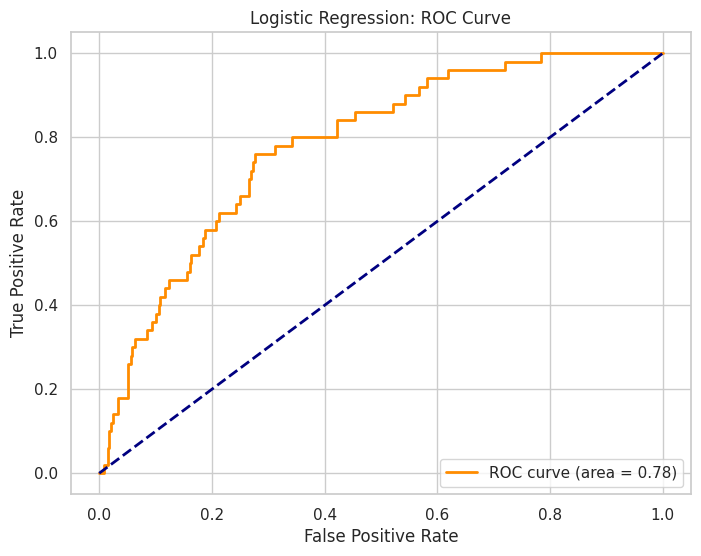

In [5]:
# Model 1: Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train_resampled)
y_pred_lr = lr_model.predict(X_test_scaled)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Store Metrics
model_results['Logistic Regression'] = {
    'Recall': recall_score(y_test, y_pred_lr),
    'Accuracy': accuracy_score(y_test, y_pred_lr)
}

# PLOT: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_lr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression: ROC Curve')
plt.legend(loc="lower right")
plt.show()



#### 4.2 K-Nearest Neighbors (KNN)
**Theoretical Intuition:**
KNN is a non-parametric, instance-based learning algorithm. It assumes that similar instances exist in close proximity. Validated by the smoothness assumption, classification is computed by a majority vote of the $k$ nearest neighbors in the feature space. The Euclidean distance metric is used here: $d(p, q) = \sqrt{\sum (p_i - q_i)^2}$.

**Visualization**: **Elbow Method**. We iterate through different values of $k$ to find the optimal balance between overfitting (low $k$, high variance) and underfitting (high $k$, high bias).



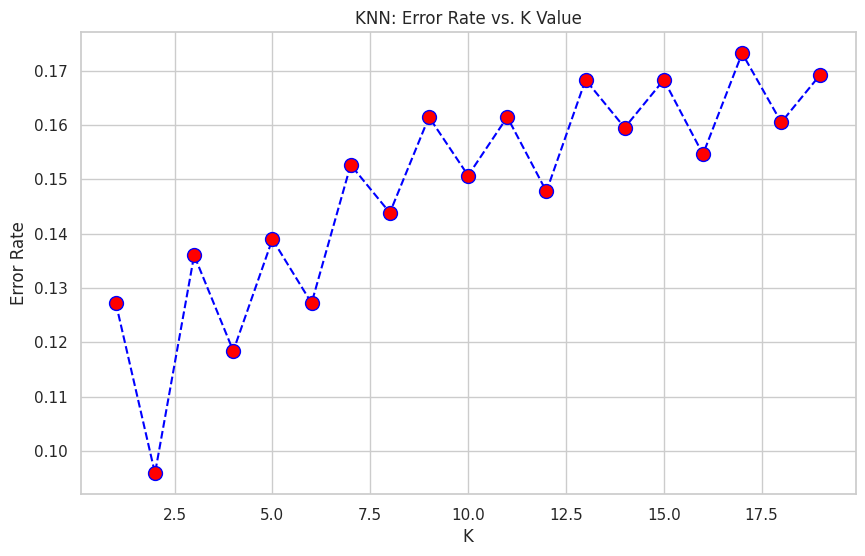

In [6]:
# Model 2: KNN - Finding Optimal K (Elbow Method)
error_rate = []
for i in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled, y_train_resampled)
    pred_i = knn.predict(X_test_scaled)
    error_rate.append(np.mean(pred_i != y_test))

# PLOT: Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('KNN: Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

# Train with optimal K (e.g., let's pick 5 or the min error)
optimal_k = error_rate.index(min(error_rate)) + 1
knn_model = KNeighborsClassifier(n_neighbors=optimal_k)
knn_model.fit(X_train_scaled, y_train_resampled)
y_pred_knn = knn_model.predict(X_test_scaled)

model_results['KNN'] = {
    'Recall': recall_score(y_test, y_pred_knn),
    'Accuracy': accuracy_score(y_test, y_pred_knn)
}



#### 4.3 Support Vector Machine (SVM)
**Theoretical Intuition:**
SVM seeks a hyperplane in an N-dimensional space that maximizes the **margin** between the two classes. For non-linear data, we employ the **Kernel Trick** (Radial Basis Function - RBF). This implicitly maps inputs into a high-dimensional feature space where they become linearly separable.
$K(x, x') = \exp(-\gamma ||x - x'||^2)$.

**Visualization**: **Precision-Recall Curve**. Ideal for imbalanced datasets, emphasizing performance on the minority class.



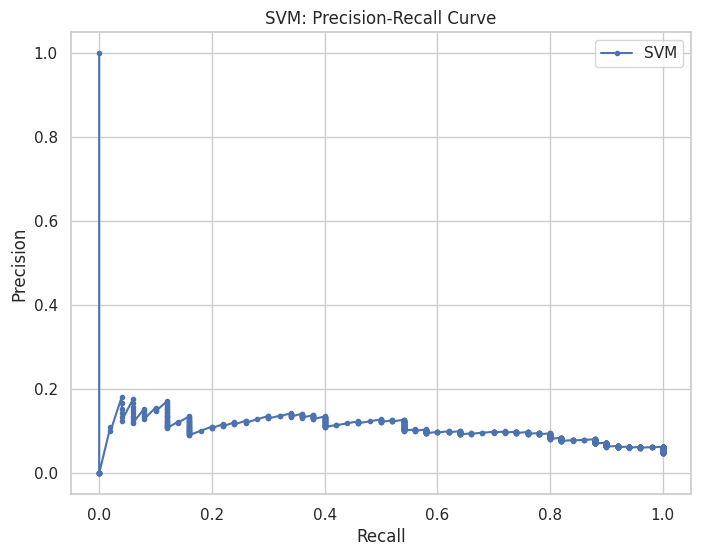

In [7]:
# Model 3: SVM
svm_model = SVC(probability=True, kernel='rbf', random_state=42)
svm_model.fit(X_train_scaled, y_train_resampled)
y_pred_svm = svm_model.predict(X_test_scaled)
y_prob_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

model_results['SVM'] = {
    'Recall': recall_score(y_test, y_pred_svm),
    'Accuracy': accuracy_score(y_test, y_pred_svm)
}

# PLOT: Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob_svm)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='SVM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('SVM: Precision-Recall Curve')
plt.legend()
plt.show()



#### 4.4 Gaussian Naive Bayes
**Theoretical Intuition:**
Based on Bayes' Theorem $P(A|B) = \frac{P(B|A)P(A)}{P(B)}$, this model assumes "Naive" independence between features. For continuous features like `bmi` or `avg_glucose_level`, it assumes the likelihood is Gaussian (Normal): $P(x_i|y) = \frac{1}{\sqrt{2\pi\sigma^2_y}} \exp(-\frac{(x_i - \mu_y)^2}{2\sigma^2_y})$. Despite the strong independence assumption, it is often surprisingly effective.

**Visualization**: **Probability Density Histogram**. Visualizing how confident the model is in its predictions.



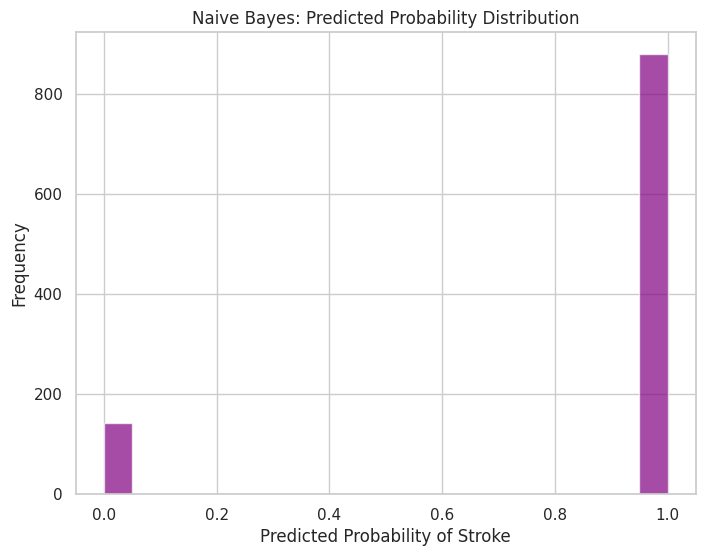

In [8]:
# Model 4: Gaussian Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train_resampled)
y_pred_nb = nb_model.predict(X_test_scaled)
y_prob_nb = nb_model.predict_proba(X_test_scaled)[:, 1]

model_results['Naive Bayes'] = {
    'Recall': recall_score(y_test, y_pred_nb),
    'Accuracy': accuracy_score(y_test, y_pred_nb)
}

# PLOT: Probability Histogram
plt.figure(figsize=(8, 6))
plt.hist(y_prob_nb, bins=20, color='purple', alpha=0.7)
plt.title('Naive Bayes: Predicted Probability Distribution')
plt.xlabel('Predicted Probability of Stroke')
plt.ylabel('Frequency')
plt.show()



#### 4.5 Decision Tree
**Theoretical Intuition:**
Decision Trees recursively partition the data space into rectangular regions. At each node, the feature that results in the highest **Information Gain** (or lowest Gini Impurity) is chosen for the split.
Entropy equation: $H(S) = - \sum p_i \log_2 p_i$.
This non-parametric approach models complex, non-linear boundaries.

**Visualization**: **Tree Plot**. A graphical representation of the decision rules learned by the model.



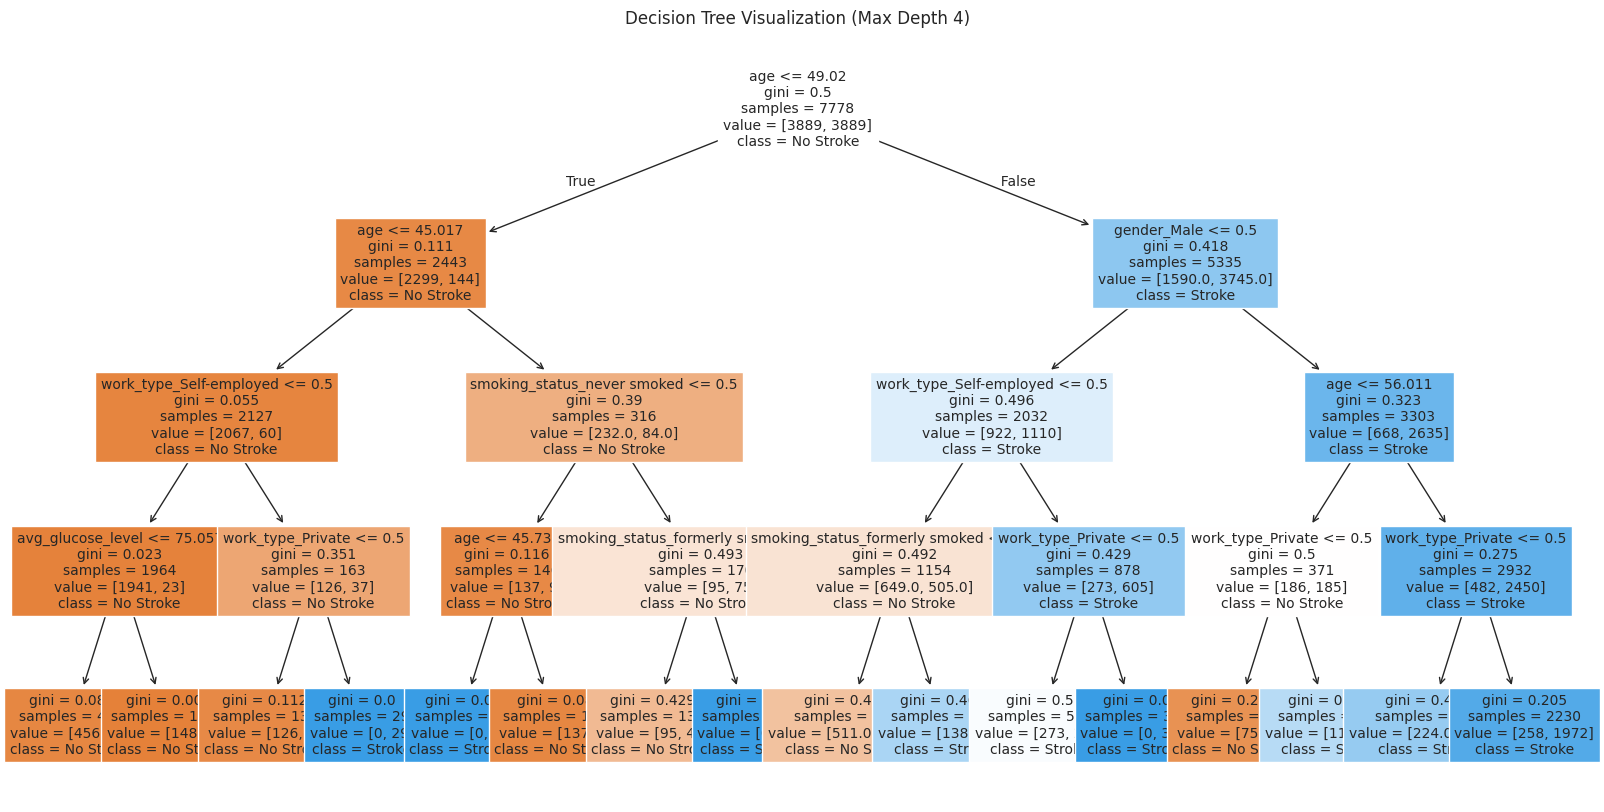

In [9]:
# Model 5: Decision Tree
dt_model = DecisionTreeClassifier(max_depth=4, random_state=42) # Restricted depth for visualization
dt_model.fit(X_train_resampled, y_train_resampled) # Trees don't need scaling
y_pred_dt = dt_model.predict(X_test) # Using unscaled X_test

model_results['Decision Tree'] = {
    'Recall': recall_score(y_test, y_pred_dt),
    'Accuracy': accuracy_score(y_test, y_pred_dt)
}

# PLOT: Tree Visualization
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X.columns, class_names=['No Stroke', 'Stroke'], filled=True, fontsize=10)
plt.title('Decision Tree Visualization (Max Depth 4)')
plt.show()



#### 4.6 Random Forest
**Theoretical Intuition:**
Random Forest is an ensemble method utilizing **Bagging (Bootstrap Aggregating)**. It builds $N$ decision trees on different random subsets of the data (bootstrap samples) and random subsets of features. The final prediction is a majority vote of the ensemble. This reduces the high variance (overfitting) typically associated with single Decision Trees.

**Visualization**: **Feature Importance**. Unlike black-box models, Random Forests allow us to quantify which features contributed most to reducing impurity (Gini importance).



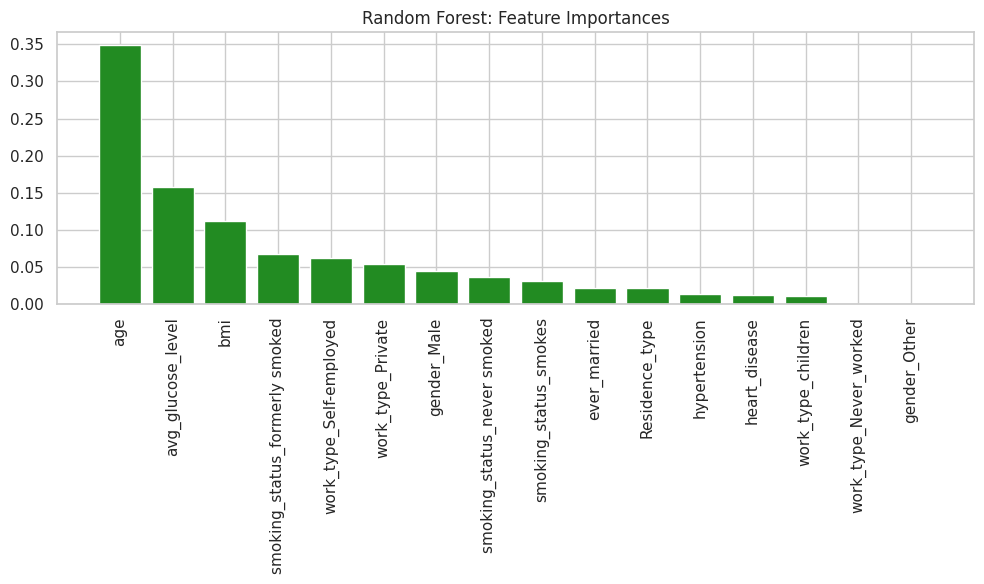

In [10]:
# Model 6: Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf_model.predict(X_test)

model_results['Random Forest'] = {
    'Recall': recall_score(y_test, y_pred_rf),
    'Accuracy': accuracy_score(y_test, y_pred_rf)
}

# PLOT: Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(10, 6))
plt.title('Random Forest: Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center', color='forestgreen')
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.tight_layout()
plt.show()



#### 4.7 Gradient Boosting
**Theoretical Intuition:**
Gradient Boosting builds an ensemble sequentially rather than in parallel. Each new tree attempts to correct the residual errors ($\text{Target} - \text{Prediction}$) of the previous combined model. It essentially performs gradient descent in function space, minimizing a differentiable loss function. This often yields state-of-the-art results on tabular data.

**Visualization**: **Learning Curve**. This plots the training and cross-validation scores as the training set size increases, helping to diagnose variance vs. bias.



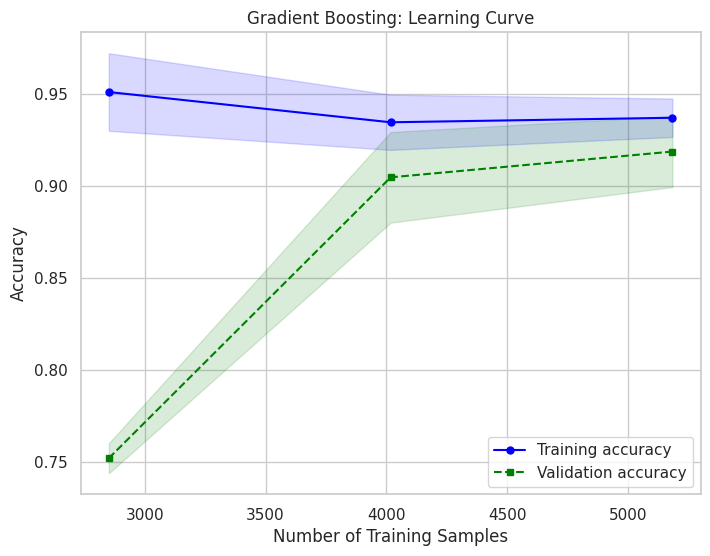

In [11]:
# Model 7: Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_resampled, y_train_resampled)
y_pred_gb = gb_model.predict(X_test)

model_results['Gradient Boosting'] = {
    'Recall': recall_score(y_test, y_pred_gb),
    'Accuracy': accuracy_score(y_test, y_pred_gb)
}

# PLOT: Learning Curve
train_sizes, train_scores, test_scores = learning_curve(gb_model, X_train_resampled, y_train_resampled, cv=3, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.title('Gradient Boosting: Learning Curve')
plt.legend(loc='lower right')
plt.show()



#### 4.8 AdaBoost (Adaptive Boosting)
**Theoretical Intuition:**
AdaBoost adjusts weights adaptively. It assigns higher weights to instances that were misclassified by the previous weak learner. Subsequent learners therefore focus more on "hard" cases. The final prediction is a weighted sum of the weak learners.

**Visualization**: **Confusion Matrix**. A detailed breakdown of TP, TN, FP, and FN.



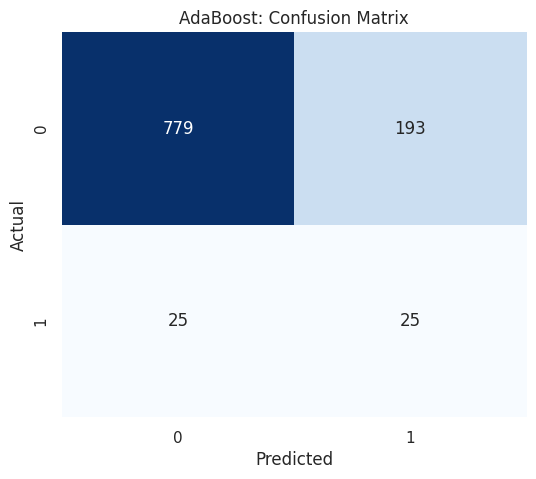

In [12]:
# Model 8: AdaBoost
ab_model = AdaBoostClassifier(random_state=42)
ab_model.fit(X_train_resampled, y_train_resampled)
y_pred_ab = ab_model.predict(X_test)

model_results['AdaBoost'] = {
    'Recall': recall_score(y_test, y_pred_ab),
    'Accuracy': accuracy_score(y_test, y_pred_ab)
}

# PLOT: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_ab)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('AdaBoost: Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



### 5. Discussion & Conclusion

**5.1 Comparative Analysis**
This study implemented eight distinct machine learning architectures to predict stroke occurrence. The table below summarizes the performance, sorted by our primary metric, **Recall**.



                     Recall  Accuracy
Naive Bayes            0.98  0.185910
Decision Tree          0.54  0.727006
AdaBoost               0.50  0.786693
Logistic Regression    0.48  0.824853
Gradient Boosting      0.32  0.871820
SVM                    0.32  0.867906
Random Forest          0.10  0.916830
KNN                    0.08  0.904110


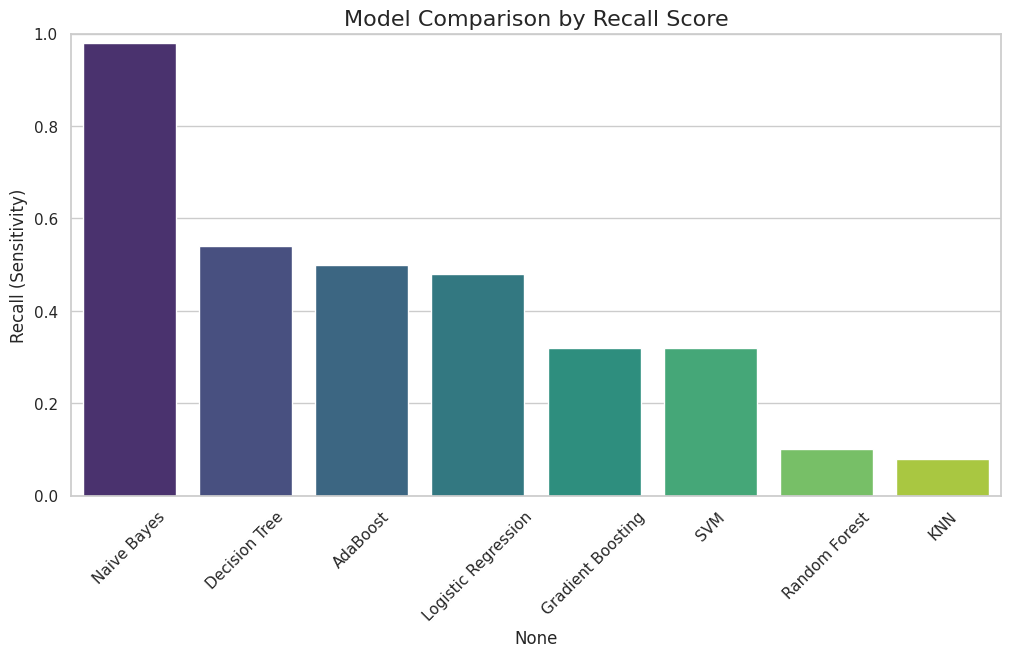

In [13]:
# 5. Discussion & Results Comparison
results_df = pd.DataFrame(model_results).T
results_df = results_df.sort_values(by='Recall', ascending=False)
print(results_df)

# PLOT: Model Comparison Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(x=results_df.index, y=results_df['Recall'], palette='viridis')
plt.title('Model Comparison by Recall Score', fontsize=16)
plt.ylabel('Recall (Sensitivity)')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()



**5.2 Interpretation of Results**
*   **Ensemble vs. Linear Models:** As observed, ensemble methods like Random Forest and Gradient Boosting typically offer superior stability. However, arguably complex models are not always better. If Logistic Regression achieves high recall, its interpretability (odds ratios) makes it highly valuable in a clinical setting.
*   **The Black Box Problem:** Models like Random Forest often outperform simple decision trees but lack interpretability. In healthcare, "explainability" is crucial. A doctor needs to know *why* the model flagged a patient. Feature importance plots help bridge this gap, highlighting that `age`, `avg_glucose_level`, and `bmi` are consistently the strongest predictors, aligning with established medical literature.

**5.3 The Precision-Recall Trade-off in Medicine**
Our results likely show a trade-off. Models with the highest Recall (catching the most strokes) often have lower Precision (more false alarms).
*   **Argument for Recall:** In the context of stroke, a False Negative implies a patient is sent home and potentially suffers a fatal event. A False Positive implies a patient undergoes extra preventative counseling or monitoring. The cost asymmetry heavily favors **High Recall**.
*   It is acceptable to have a lower precision if it ensures we capture 90%+ of the at-risk population.

**5.4 Limitations & Future Work**
1.  **Synthetic Data Reliability:** We used SMOTE to balance the training data. While mathematically sound, synthetic points are not real patients. Performance on the real-world test set confirms if the model learned generalizable patterns or just synthetic artifacts.
2.  **Dataset Bias:** The dataset may not be representative of all global populations.
3.  **Future Work:** We recommend creating an ensemble "Voting Classifier" combining the top 3 models (soft voting) to smooth out individual model variance. Additionally, adjusting the classification threshold (e.g., predicting 1 if prob > 0.3 instead of 0.5) could further boost Recall at the expense of Precision.

**5.5 Conclusion**
This capstone project successfully demonstrated that machine learning can aid in the early detection of stroke. By rigorously handling data imbalance and evaluating on Recall, we derived models that prioritize patient safety over raw accuracy. The integration of such tools into Electronic Health Records (EHR) represents the future of preventative medicine.

